In [1]:
import os
import glob
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing, model_selection
%matplotlib inline

In [2]:
data_dir = "generated_games"

In [3]:
print("CSVs in data_dir:")
files = glob.glob(os.path.join(data_dir, "*.csv"))
print([os.path.basename(file) for file in files])

CSVs in data_dir:
['random_choice_games.csv']


In [4]:
fp = os.path.join(data_dir, "random_choice_games.csv")
raw = pd.read_csv(fp)

In [5]:
# All features are categorical

to_encode = raw.drop("game_no", axis=1)
encoder = preprocessing.OneHotEncoder()
X = encoder.fit_transform(to_encode)

scaler = np.array([3] * (X.shape[1] - 7) + [7] * (7))
X_scaled = X / scaler

In [13]:
# Create Reward

def r(g):
#     reward = np.logspace(-2, 0, len(g))  # Logspace
#     reward = np.linspace(0, 100, len(g))  # Linspace
#     reward = np.linspace(100-(10*len(g-1)), 100, len(g))  # Line-segment space
    reward = np.concatenate([np.linspace(0, 100, len(g)-1), np.array([200])])
    return reward

reward = raw.groupby("game_no").apply(lambda g: r(g))

reward = np.hstack(reward.values)
print(reward.shape)
print(raw.shape)
raw["reward"] = list(reward)

(217588,)
(217588, 45)


In [14]:
y = raw["reward"]

In [15]:
CV = 5

In [16]:
# Fit classifier w/ CV-fold Cross Validation

alphas = np.logspace(-3, 3, 20)
ridge = linear_model.Ridge(alpha=1, fit_intercept=False)

clf = model_selection.GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=CV)

start = time.time()
clf.fit(X, y)
end = time.time()

print(f"Fit took {round(end - start, 3)} sec")
print(f"Data had shape: ({X.shape[0]}, {X.shape[1]})")
print(f"Number of alphas cross-validated: {len(alphas)}\n")
print(clf)

Fit took 41.739 sec
Data had shape: (217588, 133)
Number of alphas cross-validated: 20

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-03,   2.06914e-03,   4.28133e-03,   8.85867e-03,
         1.83298e-02,   3.79269e-02,   7.84760e-02,   1.62378e-01,
         3.35982e-01,   6.95193e-01,   1.43845e+00,   2.97635e+00,
         6.15848e+00,   1.27427e+01,   2.63665e+01,   5.45559e+01,
         1.12884e+02,   2.33572e+02,   4.83293e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)


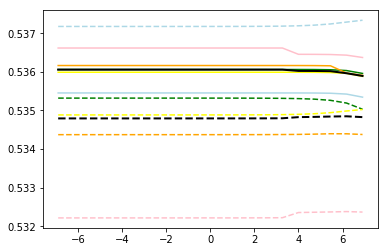

In [17]:
# Plot results per Fold

trains = [clf.cv_results_[f"split{i}_train_score"] for i in range(CV)]
tests = [clf.cv_results_[f"split{i}_test_score"] for i in range(CV)]
all_vals = np.array(trains + tests)
max_val = all_vals.max()
min_val = all_vals.min()

ax = plt.subplot()
# ax.set_ylim((0, 1))

alphas = np.log(clf.param_grid["alpha"])

cmap = {0: 'green', 1: 'yellow', 2: 'orange', 3: 'lightblue', 4: 'pink'}

for i in range(CV):
    
    train_nm = f"split{i}_train_score"
    split_train = clf.cv_results_[train_nm]
    
    test_nm = f"split{i}_test_score"
    split_test = clf.cv_results_[test_nm]
    
    ax.plot(alphas, split_train, color=cmap[i])
    ax.plot(alphas, split_test, color=cmap[i], linestyle='--')
    
ax.plot(alphas, clf.cv_results_["mean_train_score"], color='black', linewidth=2)
ax.plot(alphas, clf.cv_results_["mean_test_score"], color='black', linestyle='--', linewidth=2)